## Data Lookup

In [1]:
# Start Spark Session
from pyspark.sql import SparkSession
spark = (
    SparkSession.builder.appName("MAST30034 Project 2 BNPL")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .config("spark.executor.memory", "8g")
    .getOrCreate()
)

22/09/07 21:35:54 WARN Utils: Your hostname, LAPTOP-URHBN55Q resolves to a loopback address: 127.0.1.1; using 10.13.207.233 instead (on interface wifi0)
22/09/07 21:35:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/07 21:35:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
consumer = spark.read.csv("../data/tables/tbl_consumer.csv", header=True, sep="|")

In [3]:
consumer.show(1, vertical=True)

-RECORD 0---------------------------
 name        | Yolanda Williams     
 address     | 413 Haney Gardens... 
 state       | WA                   
 postcode    | 6935                 
 gender      | Female               
 consumer_id | 1195503              
only showing top 1 row



In [4]:
details = spark.read.parquet("../data/tables/consumer_user_details.parquet")

In [5]:
details.show(10, vertical=True)

-RECORD 0--------------
 user_id     | 1       
 consumer_id | 1195503 
-RECORD 1--------------
 user_id     | 2       
 consumer_id | 179208  
-RECORD 2--------------
 user_id     | 3       
 consumer_id | 1194530 
-RECORD 3--------------
 user_id     | 4       
 consumer_id | 154128  
-RECORD 4--------------
 user_id     | 5       
 consumer_id | 712975  
-RECORD 5--------------
 user_id     | 6       
 consumer_id | 407340  
-RECORD 6--------------
 user_id     | 7       
 consumer_id | 511685  
-RECORD 7--------------
 user_id     | 8       
 consumer_id | 448088  
-RECORD 8--------------
 user_id     | 9       
 consumer_id | 650435  
-RECORD 9--------------
 user_id     | 10      
 consumer_id | 1058499 
only showing top 10 rows



In [6]:
merchants = spark.read.parquet("../data/tables/tbl_merchants.parquet")

In [7]:
merchants.show(3, vertical=True)

-RECORD 0----------------------------
 name         | Felis Limited        
 tags         | ((furniture, home... 
 merchant_abn | 10023283211          
-RECORD 1----------------------------
 name         | Arcu Ac Orci Corp... 
 tags         | ([cable, satellit... 
 merchant_abn | 10142254217          
-RECORD 2----------------------------
 name         | Nunc Sed Company     
 tags         | ([jewelry, watch,... 
 merchant_abn | 10165489824          
only showing top 3 rows



In [8]:
transactions = spark.read.parquet("../data/tables/transactions_20210228_20210827_snapshot/")

In [9]:
transactions.show(1, vertical=True)

-RECORD 0------------------------------
 user_id        | 18478                
 merchant_abn   | 62191208634          
 dollar_value   | 63.255848959735246   
 order_id       | 949a63c8-29f7-4ab... 
 order_datetime | 2021-08-20           
only showing top 1 row



In [10]:
# Join consumers with their respective details
consumer_user = consumer.join(details, on="consumer_id")

In [11]:
# Join consumers with their respective transactions
consumer_transactions = consumer_user.join(transactions, on="user_id")

In [12]:
consumer_transactions.show(5, vertical=True)

-RECORD 0------------------------------
 user_id        | 7                    
 consumer_id    | 511685               
 name           | Andrea Jones         
 address        | 122 Brandon Cliff    
 state          | QLD                  
 postcode       | 4606                 
 gender         | Female               
 merchant_abn   | 33064796871          
 dollar_value   | 373.0873675184212    
 order_id       | fe188788-b89f-4dd... 
 order_datetime | 2021-08-20           
-RECORD 1------------------------------
 user_id        | 7                    
 consumer_id    | 511685               
 name           | Andrea Jones         
 address        | 122 Brandon Cliff    
 state          | QLD                  
 postcode       | 4606                 
 gender         | Female               
 merchant_abn   | 68435002949          
 dollar_value   | 232.5364986739752    
 order_id       | b4a89891-a113-45e... 
 order_datetime | 2021-08-20           
-RECORD 2------------------------------


In [13]:
# Join transactions with the respective merchants
consumer_merchants = consumer_transactions.join(merchants, on="merchant_abn")

In [14]:
consumer_merchants.show(5, vertical=True)

-RECORD 0------------------------------
 merchant_abn   | 33064796871          
 user_id        | 7                    
 consumer_id    | 511685               
 name           | Andrea Jones         
 address        | 122 Brandon Cliff    
 state          | QLD                  
 postcode       | 4606                 
 gender         | Female               
 dollar_value   | 373.0873675184212    
 order_id       | fe188788-b89f-4dd... 
 order_datetime | 2021-08-20           
 name           | Curabitur Massa C... 
 tags           | ((computer progra... 
-RECORD 1------------------------------
 merchant_abn   | 68435002949          
 user_id        | 7                    
 consumer_id    | 511685               
 name           | Andrea Jones         
 address        | 122 Brandon Cliff    
 state          | QLD                  
 postcode       | 4606                 
 gender         | Female               
 dollar_value   | 232.5364986739752    
 order_id       | b4a89891-a113-45e... 


In [15]:
# Explore product tags for purchase frequency
consumer_merchants.groupby("tags").count().show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------+-----+
|tags                                                                                                             |count|
+-----------------------------------------------------------------------------------------------------------------+-----+
|((lawn and garden suppLy outlets, including nurseries), (a), (take rate: 6.02))                                  |148  |
|[[watch, clock, and jewelry repair shops], [a], [take rate: 5.93]]                                               |2502 |
|[[florists supplies, nursery stock, and flowers], [a], [take rate: 5.58]]                                        |163  |
|([artist supply and craft shops], [a], [take rate: 6.04])                                                        |452  |
|((tent and awning shops), (b), (take rate: 3.43))                                                                |336  |
|([tent and awning shops

In [16]:
from pyspark.sql import functions as F
from pyspark.sql.types import *
@F.udf(StringType())
def normalize_tags(col):
    return col.replace("(", "[").replace(")", "]")[1:-1]

In [17]:
consumer_merchants = consumer_merchants.withColumn("tags", normalize_tags(F.col("tags")))

In [18]:
consumer_merchants.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- user_id: long (nullable = true)
 |-- consumer_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- name: string (nullable = true)
 |-- tags: string (nullable = true)



In [32]:
consumer_merchants = consumer_merchants.withColumn("categories", F.regexp_extract("tags", "(?<=\[)(.*?)(?=\])", 1))

In [49]:
consumer_merchants = consumer_merchants.withColumn("revenue_level", F.regexp_extract("tags", "(?<=,\s\[)([a-e]+?)(?=\],)", 1))

In [52]:
consumer_merchants = consumer_merchants.withColumn("take_rate", F.regexp_extract("tags", "(?<=\[take rate: )(.*?)(?=\])", 1))

In [60]:
consumer_merchants = consumer_merchants.withColumn("take_rate", F.col("take_rate").astype(FloatType()))

In [66]:
@F.udf(StringType())
def clean_string(col):
    col = col.lower()
    return " ".join(col.split())

In [67]:
consumer_merchants = consumer_merchants.withColumn("categories", clean_string(F.col("categories")))

In [73]:
category_take_rates = consumer_merchants.select(["categories", "revenue_level", "take_rate"]).toPandas()

In [82]:
import pandas as pd
pd.set_option('display.max_rows', None)

/home/aaa/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='revenue_level', ylabel='take_rate'>

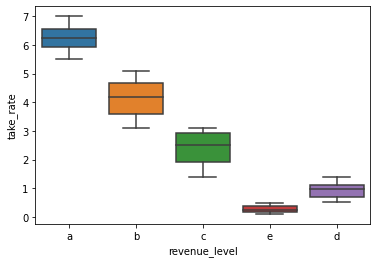

In [74]:
import seaborn as sns
sns.boxplot(category_take_rates["revenue_level"], category_take_rates["take_rate"])

Revenue levels can be categorized by its take rate

In [86]:
category_take_rates.groupby(["categories", "revenue_level"]).size().agg(
  {'count': lambda x: x, 'percent':lambda x: x / x.groupby(level=0).sum() * 100}
  ).unstack(level=0).reset_index()

,categories,revenue_level,count,percent
0,"antique shops - sales, repairs, and restoratio...",a,7645.0,16.595394
1,"antique shops - sales, repairs, and restoratio...",b,19240.0,41.765255
2,"antique shops - sales, repairs, and restoratio...",c,17204.0,37.345605
3,"antique shops - sales, repairs, and restoratio...",d,1693.0,3.675082
4,"antique shops - sales, repairs, and restoratio...",e,285.0,0.618664
5,art dealers and galleries,a,1506.0,27.547101
6,art dealers and galleries,b,2966.0,54.252789
7,art dealers and galleries,c,858.0,15.694165
8,art dealers and galleries,d,14.0,0.256082
9,art dealers and galleries,e,123.0,2.249863


We can see which categories provide the better amount in revenue for our BNPL company